# Step 1: Import all necessary libraries


In [2]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

print("--- Step 1: Libraries Imported ---")
print("We need numpy for array manipulation, matplotlib for plotting, torch to create tensors,")
print("and sklearn for data normalization.\n")

--- Step 1: Libraries Imported ---
We need numpy for array manipulation, matplotlib for plotting, torch to create tensors,
and sklearn for data normalization.



# Step 2: Define and Generate the NARMA Time-Series Data


--- Step 2: Generating the NARMA Time-Series ---
Unlike the damped pendulum, NARMA data isn't from a physical simulation.
It's generated from a mathematical formula where each new point depends on previous points.

Generated 240 raw NARMA data points with an order of 5.



/tmp/ipykernel_1711120/273995865.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  term2 = 0.05 * y[t-1] * np.sum(y[t-i-1] for i in range(order))


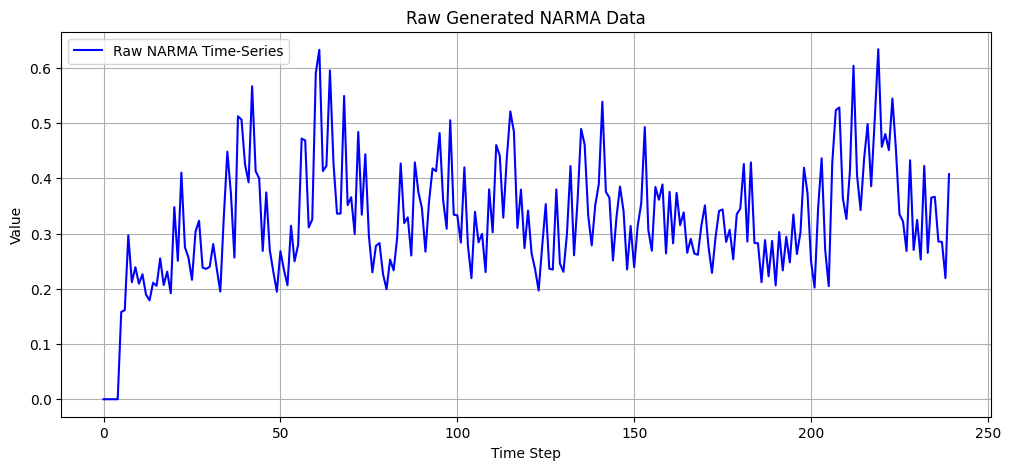

In [9]:
print("--- Step 2: Generating the NARMA Time-Series ---")
print("Unlike the damped pendulum, NARMA data isn't from a physical simulation.")
print("It's generated from a mathematical formula where each new point depends on previous points.\n")

def generate_narma_data(n_samples, order):
    """
    Generates a NARMA (Non-linear Autoregressive Moving Average) time-series.
    The value at time 't' depends on previous values of 'y' and a random input 'u'.
    """
    # A random, uniformly distributed input signal
    u = np.random.uniform(0, 0.5, n_samples)
    y = np.zeros(n_samples)

    # The 'order' (memory) of the system. We need 'order' previous points to start.
    for t in range(order, n_samples):
        term1 = 0.3 * y[t-1]
        term2 = 0.05 * y[t-1] * np.sum(y[t-i-1] for i in range(order))
        term3 = 1.5 * u[t-order] * u[t-1]
        term4 = 0.1
        y[t] = term1 + term2 + term3 + term4
        
    # Reshape to (n_samples, 1) for the scaler
    return y.reshape(-1, 1)

# Set the parameters for data generation
n_samples = 240  # Total number of data points to generate
order = 5        # The memory of the system (how far back it looks)

# Generate the raw NARMA time-series
narma_raw = generate_narma_data(n_samples, order)

print(f"Generated {n_samples} raw NARMA data points with an order of {order}.\n")

# Visualize the raw NARMA data
plt.figure(figsize=(12, 5))
plt.plot(narma_raw, 'b-', label='Raw NARMA Time-Series')
plt.title('Raw Generated NARMA Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Step 3: Normalize the Data



--- Step 3: Normalizing the Data for the Model ---
Just like before, we scale the data to the range [-1, 1] for better training performance.

Data has been normalized.



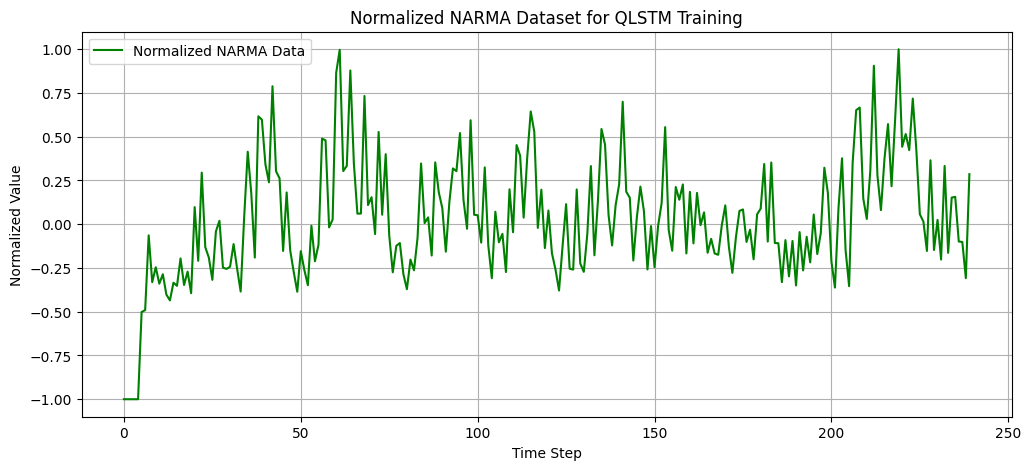

In [ ]:
print("\n--- Step 3: Normalizing the Data for the Model ---")
print("Just like before, we scale the data to the range [-1, 1] for better training performance.")

# Use scikit-learn's MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(narma_raw)

print("\nData has been normalized.\n")

# Visualize the normalized dataset
plt.figure(figsize=(12, 5))
plt.plot(dataset, 'g-', label='Normalized NARMA Data')
plt.title('Normalized NARMA Dataset for QLSTM Training')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.ylim(-1.1, 1.1)
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Transform Data into Sequences


In [16]:
print("\n--- Step 4: Creating Input Sequences and Target Values ---")

def transform_narma_data(data, seq_length):
    """
    Transforms NARMA data into input-output pairs for sequence prediction.
    """
    x = []
    y = []
    # Note the loop range is different from damped_shm.py
    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    # Convert directly to 3D PyTorch tensors
    x_tensor = torch.from_numpy(np.array(x)).float()
    y_tensor = torch.from_numpy(np.array(y)).float()
    
    return x_tensor, y_tensor

# Set the sequence length (how many past steps the model sees)
# The default for NARMA is 10, because the order of the system is 10.
seq_length = 4

# Transform the normalized data
x_sequences, y_targets = transform_narma_data(dataset, seq_length)

print(f"\nUsing a sequence length of {seq_length}, we created {len(x_sequences)} training examples.")
print("Let's look at the first few examples:\n")

for i in range(3):
    print(f"Example {i+1}:")
    print(f"  Input Sequence (x): {x_sequences[i].squeeze().numpy().round(3)}")
    print(f"  Target Value (y):   {y_targets[i].squeeze().numpy().round(3)}\n")


--- Step 4: Creating Input Sequences and Target Values ---

Using a sequence length of 4, we created 235 training examples.
Let's look at the first few examples:

Example 1:
  Input Sequence (x): [-1. -1. -1. -1.]
  Target Value (y):   -1.0

Example 2:
  Input Sequence (x): [-1. -1. -1. -1.]
  Target Value (y):   -0.5019999742507935

Example 3:
  Input Sequence (x): [-1.    -1.    -1.    -0.502]
  Target Value (y):   -0.4909999966621399



# Step 5: Final Check of Data Shapes


In [12]:
print("\n--- Step 5: Final Data Shape for the QLSTM Model ---")
print("The narma.py script produces a 3D input tensor directly.")
print(f"Shape of the input sequences tensor (X): {x_sequences.shape}")
print(f"Shape of the target values tensor (Y):  {y_targets.shape}")
print("\nThis 3D shape is exactly what the QLSTM model expects, so no '.unsqueeze()' is needed later.")




--- Step 5: Final Data Shape for the QLSTM Model ---
The narma.py script produces a 3D input tensor directly.
Shape of the input sequences tensor (X): torch.Size([236, 4, 1])
Shape of the target values tensor (Y):  torch.Size([236, 1])

This 3D shape is exactly what the QLSTM model expects, so no '.unsqueeze()' is needed later.
